In [169]:
import pandas as pd
import pandahouse as ph
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [117]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [118]:
#пишем запрос, и получаем данные из clickhouse в pandas dataframe
query = """
SELECT count() rows
FROM default.ldn_listings 
"""
result = ph.read_clickhouse(query, connection=connection)
print(result)


    rows
0  85207


In [119]:
#пишем запрос, и получаем данные из clickhouse в pandas dataframe
query = """
SELECT 
    toFloat64OrNull(replaceRegexpAll(price, '[$,]', '')) as price,
    room_type,
    id
FROM default.ldn_listings 
ORDER BY  id ASC
LIMIT 1000
"""
df = ph.read_clickhouse(query, connection=connection)
df.head()


,price,room_type,id
0,65.0,Private room,13913
1,100.0,Entire home/apt,15400
2,300.0,Entire home/apt,17402
3,150.0,Private room,17506
4,65.0,Entire home/apt,25023


In [120]:
df.groupby('room_type').quantile(q=0.75)

,price,id
room_type,,
Entire home/apt,160.00,463610.50
Hotel room,157.00,73302.50
Private room,70.00,453442.50
Shared room,69.25,472261.75


In [136]:
#пишем запрос, и получаем данные из clickhouse в pandas dataframe
query = """
SELECT 
    id,
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price,
    toFloat32OrNull(review_scores_rating) as review_scores_rating
    
FROM default.ldn_listings 
WHERE review_scores_rating is not null
ORDER BY id ASC
LIMIT 1000
"""
df = ph.read_clickhouse(query, connection=connection)
df.head()

,id,room_type,price,review_scores_rating
0,13913,Private room,65.0,97.0
1,15400,Entire home/apt,100.0,96.0
2,17402,Entire home/apt,300.0,94.0
3,25023,Entire home/apt,65.0,93.0
4,25123,Private room,29.0,96.0


In [139]:
df_g = df.groupby('room_type') \
    .agg({'price': 'mean', 'review_scores_rating': 'mean'})


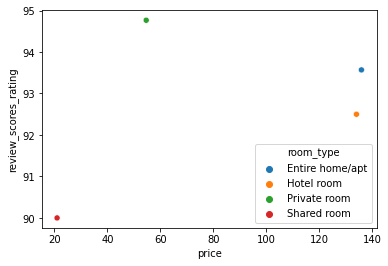

In [141]:
sns.scatterplot(data= df_g, x='price', y='review_scores_rating', hue = 'room_type')

In [142]:
#пишем запрос, и получаем данные из clickhouse в pandas dataframe
query = """
    SELECT
        DISTINCT host_id,
        host_verifications

    FROM default.ldn_listings
    WHERE experiences_offered != 'none'
    ORDER BY id ASC
"""
df = ph.read_clickhouse(query, connection=connection)
df.head()

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."


In [143]:
df['host_verifications'] = df.apply(lambda x: eval(x.host_verifications), axis=1)

In [149]:
df = df.explode('host_verifications').reset_index(drop=True)
df.head()

,host_id,host_verifications
0,54730,email
1,54730,phone
2,54730,facebook
3,54730,reviews
4,54730,offline_government_id


In [147]:
count_host = df.host_verifications.value_counts()

In [148]:
count_host

phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
Name: host_verifications, dtype: int64

In [153]:
#пишем запрос, и получаем данные из clickhouse в pandas dataframe
query = """
SELECT  
    neighbourhood_cleansed,
    experiences_offered,
    COUNT(experiences_offered) as experiences_count
FROM default.ldn_listings 
WHERE experiences_offered != 'none'
GROUP BY 
    neighbourhood_cleansed,
    experiences_offered
ORDER BY experiences_count DESC
LIMIT 100
"""
df = ph.read_clickhouse(query, connection=connection)
df.head()

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48


In [159]:
df_p=df.pivot(index = 'neighbourhood_cleansed', columns= 'experiences_offered', values='experiences_count')

In [160]:
df_p.head()

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,NaN,NaN,NaN,2.0
Barnet,7.0,7.0,3.0,5.0
Bexley,1.0,NaN,NaN,NaN
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,NaN,4.0


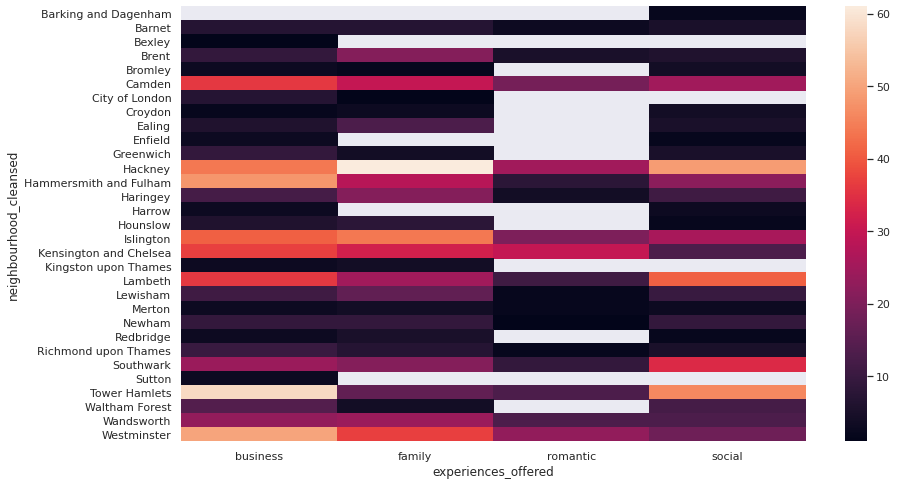

In [163]:
sns.heatmap(df_p)
sns.set(rc={'figure.figsize': (16, 8)})
cmap=sns.cubehelix_palette(as_cmap=True)

In [164]:
#пишем запрос, и получаем данные из clickhouse в pandas dataframe
query = """
    SELECT
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price, 
        experiences_offered
    FROM default.ldn_listings  
    WHERE experiences_offered != 'none'
"""
df = ph.read_clickhouse(query, connection=connection)
df.head()

,room_type,price,experiences_offered
0,Private room,65.0,business
1,Entire home/apt,100.0,romantic
2,Private room,150.0,business
3,Private room,45.0,business
4,Private room,25.0,business


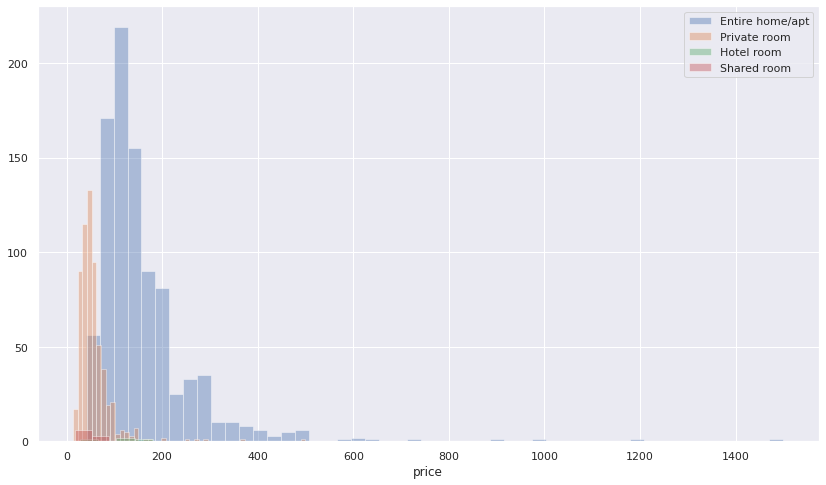

In [181]:
sns.set(rc={'figure.figsize': (14, 8)})
sns.distplot(df.query("room_type=='Entire home/apt'").price, kde=False, label='Entire home/apt')
sns.distplot(df.query("room_type=='Private room'").price, kde=False, label='Private room')
sns.distplot(df.query("room_type=='Hotel room'").price, kde=False, label='Hotel room')
sns.distplot(df.query("room_type=='Shared room'").price, kde=False, label='Shared room')
plt.legend()
plt.show()

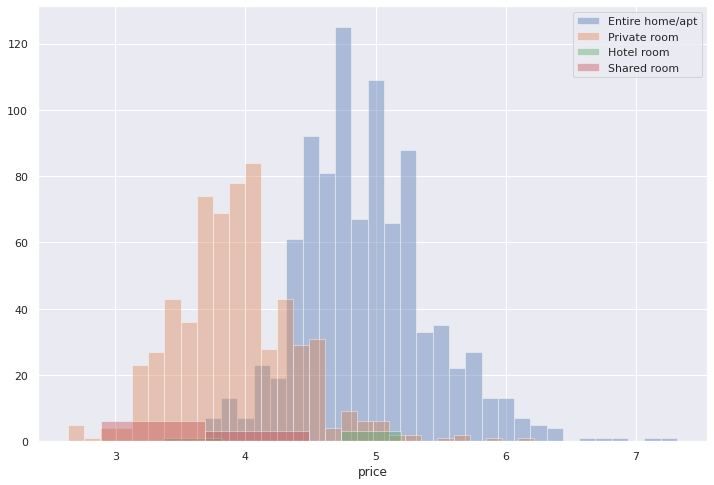

In [182]:
sns.set(rc={'figure.figsize': (12, 8)})
sns.distplot(np.log(df.query("room_type=='Entire home/apt'").price), kde=False, label='Entire home/apt')
sns.distplot(np.log(df.query("room_type=='Private room'").price), kde=False, label='Private room')
sns.distplot(np.log(df.query("room_type=='Hotel room'").price), kde=False, label='Hotel room')
sns.distplot(np.log(df.query("room_type=='Shared room'").price), kde=False, label='Shared room')
plt.legend()
plt.show()

In [188]:
#пишем запрос, и получаем данные из clickhouse в pandas dataframe
query = """
    SELECT
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price, 
        first_review
    FROM default.ldn_listings  
    WHERE first_review > '2010-01-01'
    LIMIT 1000
"""
df = ph.read_clickhouse(query, connection=connection)
df.head()

,room_type,price,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16


In [189]:
df['year']= df['first_review'].apply(lambda x: x[:-6]) 

In [195]:
df_avg =  df \
    .groupby(['room_type', 'year'], as_index=False) \
    .agg({'price': 'mean'})
df_avg.head(3)

,room_type,year,price
0,Entire home/apt,2010,103.500000
1,Entire home/apt,2011,128.792450
2,Entire home/apt,2012,135.467255


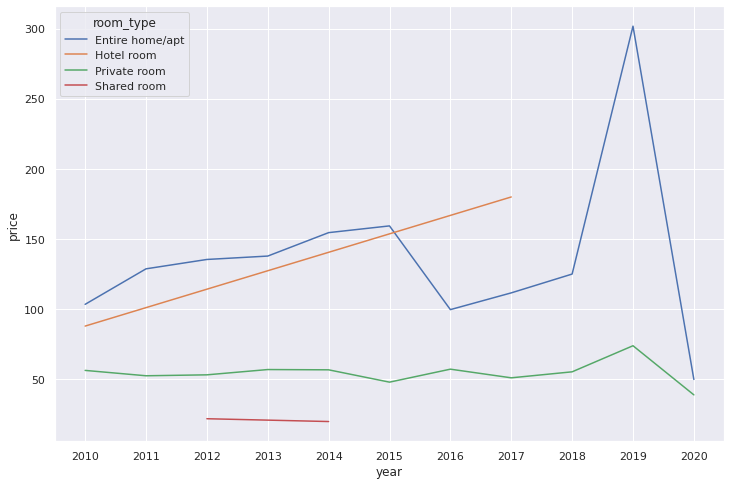

In [197]:
sns.set(rc={'figure.figsize': (12, 8)})
sns.lineplot(x='year',y='price',hue='room_type',data=df_avg)